## 4. Modeling
In this notebook we train 7 models and compare the scores to our baseline model.<br>
The  models are run an then a dataframe is created containing the scores, the best feature combinations, and 
the results from hyperparameter tuning. We store them in the variable ```results```. <br>
Finally, we write the dataframe ```results``` for every model to "../results/{MODEL}.csv". 
So for each windfarm we will find a separate model, with individual features and hyperparameters.<br><br>
In the EDA we saw that the windspeed is a very important feature. In this notebook we will iteratively check, 
what feature combinations lead to the best results.
To find the best feature combinations We define groups of features: <br> 
  - 'all' = all features
  - 'no_deg' = features without ('WD100', 'WD10')
  - 'no_deg_norm' = features without ('WD100', 'WD10', 'U100NORM', 'V100NORM')
  - 'no_comp' = features without ('U10', 'U100', 'U100NORM', 'V10', 'V100', 'V100NORM')
  - 'no_comp_plus_100Norm' = features without('U10', 'U100', 'V10', 'V100')
  - 'no_ten' = features without ('WD10CARD','U10', 'V10', 'WS10', 'WD10')
  - 'no_card' = features without 'CARD' 
  - 'no_card_100Norm' = features without ('CARD','U100NORM', 'V100NORM')
  - 'only_ws' = 'WS100' 

In [2]:
## load modules
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from modeling.functions import adjusted_RMSE, scaler_func, train_test_split_features, \
                               result_to_df, get_bestfeatures, log_to_mlflow, predict_func
from modeling.features import get_feature_combinations
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer
from copy import deepcopy
# Set random seed to ensure reproducible runs
RSEED = 42

In [2]:
# loading the cleaned dataset
data = pd.read_csv('../data/GEFCom2014Data/Wind/clean_data.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')

Use the first 75 % of the data as training/validation set and the last 25 % as a test set. In addition, get a dictionary with different feature combinations.

In [3]:
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00':]

Loading  the dictionary with the feature combinations.

In [4]:
feature_dict = get_feature_combinations()

Instantiating the 7 Regressor we will use.

In [5]:
#models = [RandomForestRegressor(), KNeighborsRegressor(), LinearRegression(), LGBMRegressor(), LinearSVR(), SVR(), XGBRegressor()] 
models = [LinearRegression()] 


Defining parameter grids for every model.

In [6]:
param_grids = {
    'RandomForestRegressor' : 
     {'n_estimators' : [100,150], 'max_depth' : np.arange(15,31,5), 'min_samples_leaf' : np.arange(10,21,10)},

     'LinearRegression' :
     {'fit_intercept' : [True]}, 
     
     'KNeighborsRegressor' :
     {'n_neighbors' : np.arange(20,141,10), 'weights' : ['uniform','distance'], 'p' : [1,2]} , 
     
     'LinearSVR' : 
     {'C': [0.01, 0.1, 1, 10, 100]}, 
    
     'SVR' : 
     {'C': [0.001, 0.01, 0.1, 1, 10]}, 
     
     'LGBMRegressor' :
     {'n_estimators' : [50], 'num_leaves': [62]}, 
     
     'XGBRegressor':
     {'random_state' : [RSEED]}
}

Settings for modeling applied to all models: <br>


In [7]:
# define the scaler, MinMaxScaler, StandardScaler, or None
scaler = MinMaxScaler()

# log to MLflow or not
log = False

# number of hreads or processes that are spawned in parallel
n_jobs = -1

Defining the scoring strategy to evaluate the performance of the cross-validated model 

In [8]:
# greater_is_better:
# Whether score_func (in this case 'adjusted_RMSE) is a score function (default), meaning high is good, or a loss function, meaning low is good. 
# In the latter case, the scorer object will sign-flip the outcome of the score_func.

scoring = make_scorer(adjusted_RMSE, greater_is_better=False)

Training the models. And writing the scores, the best feature combinations, and 
the results from hyperparameter tuning for every model to "../results/{MODEL}.csv". 

In [9]:
for model in models:
    if model.__class__.__name__ == 'RandomForestRegressor':
        param_grid = param_grids['RandomForestRegressor']

    if model.__class__.__name__ == 'XGBRegressor':
        param_grid = param_grids['XGBRegressor']

    if model.__class__.__name__ == 'LGBMRegressor':
        param_grid = param_grids['LGBMRegressor']

    if model.__class__.__name__ == 'SVR':
        param_grid = param_grids['SVR']

    if model.__class__.__name__ == 'LinearSVR':
        param_grid = param_grids['LinearSVR']

    if model.__class__.__name__ == 'KNeighborsRegressor':
        param_grid = param_grids['KNeighborsRegressor']

    if model.__class__.__name__ == 'LinearRegression':
        param_grid = param_grids['LinearRegression']
    
    # dataframe to store the best hyperparamaters, scores, best feature combinations for model/windfarm
    df_results = pd.DataFrame()

    # Run the model for every feature combination     
    for fc in feature_dict.keys():
        #print('feature combination: {}'.format(fc))

        # trainscore, testscore: rmse of predicted train/test target
        # model_dict: stores the best estimator (model with best hyperparameters)
        # cv_score: stores the rmse of the cross validation
        trainscore, testscore, model_dict, cv_score = {}, {}, {}, {}

        mse_train = 0
        mse_test = 0
        
        features = feature_dict[fc]

        # Initialize DataFrame where predictions of various zones are saved.
        y_trainpred, y_testpred = pd.DataFrame(), pd.DataFrame()

        # Run the model for every Windfarm
        for zone in data_train.ZONEID.unique():
            # Create a train and test dataframe for each windfarm, that has the currently selected fc as features
            X_train, X_test, y_train, y_test = train_test_split_features(data_train, data_test, zone, features)    
             
            # scale data if a scaler is set 
            if scaler: 
                X_train, X_test = scaler_func(X_train, X_test, scaler)

            # grid search
            cv = GridSearchCV(model, param_grid=param_grid,
                                  scoring=scoring, refit=True,
                                  n_jobs=n_jobs, verbose=2)

            # train the model
            cv.fit(X_train, y_train)

            cv_score[zone] = np.abs(cv.best_score_)
            model = cv.best_estimator_    
            model_dict[zone] = deepcopy(model)

            # predict train data with the model and calculate train-score
            y_pred = predict_func(model, X_train, y_train)
            y_trainpred = pd.concat([y_trainpred, y_pred], axis=0)
            trainscore['ZONE' + str(zone)] = mean_squared_error(y_pred, y_train,
                                                            squared=False)

            mse_train += np.power(trainscore['ZONE' + str(zone)], 2)\
                     * len(y_train)/len(data_train)

            # predict test data with the model and calculate test-score
            y_pred = predict_func(model, X_test, y_test)
            y_testpred = pd.concat([y_testpred, y_pred], axis=0)
            testscore['ZONE' + str(zone)] = mean_squared_error(y_pred, y_test,
                                                           squared=False)

            mse_test += np.power(testscore['ZONE' + str(zone)], 2) \
                    * len(y_test)/len(data_test)  # 1 / len(zones)

        
        trainscore['TOTAL'] = np.power(mse_train, 0.5)
        testscore['TOTAL'] = np.power(mse_test, 0.5)

        # track to MLFLow
        if log:
            for key in testscore.keys():
                log_to_mlflow(ZONEID=key, Model=model.__class__.__name__,
                          features=features, train_RMSE=trainscore[key],
                          test_RMSE=testscore[key], nan_removed=True,
                          zero_removed=False, mean=None,
                          hyperparameter=model.get_params(),
                          model_parameters=None, scaler=scaler)

            
        df_temp = result_to_df(model_dict, testscore,
                                     trainscore, cv_score, fc)
        df_results = pd.concat([df_results, df_temp], axis=0)

    df_results = get_bestfeatures(df_results)       

    # remove file before new file is created
    if os.path.isfile(f'../results/{df_results.MODEL.iloc[1]}.csv'):
        os.remove(f'../results/{df_results.MODEL.iloc[1]}.csv')

    # save results in csv file
    df_results.to_csv(f'../results/{df_results.MODEL.iloc[1]}.csv')    



    

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....

## Results 
The Random Forest Regressor performs best in every windfarm. The feature combinations and hyperparaneters are different for each windfarm. They can be found in the file ```RandomForestRegressor.csv```. <br>
The following plots visualize the results.

Plot validation-RMSE and test-RMSE by model for predictions aggregated over all wind farms. 

In [10]:
## define models to plot
models = ['Baseline','LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

## collect scores in the dataframe "scores"
scores= pd.DataFrame(index = models, columns = ['TESTSCORE','VALSCORE'])

for model in models:

    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')

    if model == 'Baseline':
        scores.loc[model]['VALSCORE'] = df.loc['TOTAL'].TRAINSCORE
        scores.loc[model]['TESTSCORE'] = df.loc['TOTAL'].TESTSCORE
    else:
        scores.loc[model]['VALSCORE'] = np.sqrt(np.mean(df.CV**2))
        scores.loc[model]['TESTSCORE'] = np.sqrt(np.mean(df.TESTSCORE**2))

scores.index.set_names('MODEL', inplace=True)
scores.reset_index(inplace=True)

Plot for validation and test set

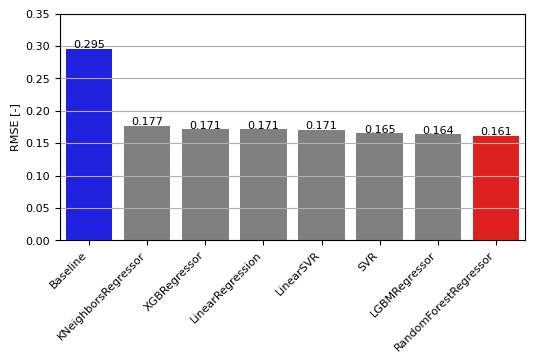

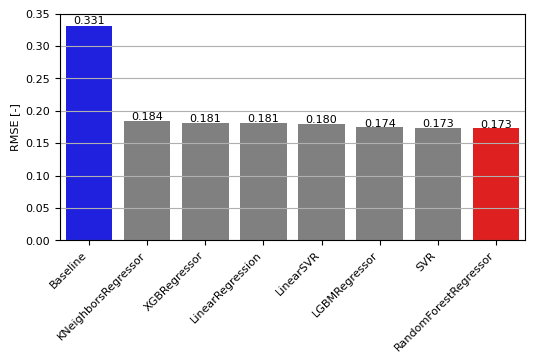

In [11]:
for scoretype in ['VALSCORE', 'TESTSCORE']: 

    scores = scores.sort_values(by = scoretype, ascending = False, ignore_index = True)

    fontsize=8
    palette = ['blue'] + 6 * ['gray'] + ['red']

    fig, ax = plt.subplots(dpi=100, figsize=(6,3))
    bp = sns.barplot(data = scores, x = 'MODEL', y = scoretype, ax=ax, dodge=False, palette = palette)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)
    ax.set(xlabel=None)
    ax.set_ylabel('RMSE [-]', fontsize=fontsize)
    ax.set_ylim([.0,.35]);
    ax.yaxis.grid()
    ax.tick_params(axis = 'both', labelsize = fontsize)

    if scoretype == 'VALSCORE':
        for index, row in scores.iterrows():
                bp.text(row.name, row.VALSCORE + row.VALSCORE/100, '{:.3f}'.format(row.VALSCORE), ha='center', fontsize=fontsize)
        fig.savefig('../images/VAL_RMSE-By-Models_Aggregated.png')

    elif scoretype == 'TESTSCORE':
        for index, row in scores.iterrows():
            bp.text(row.name, row.TESTSCORE + row.TESTSCORE/100, '{:.3f}'.format(row.TESTSCORE), ha='center', fontsize=fontsize)
        fig.savefig('../images/TEST_RMSE-By-Models_Aggregated.png')



Plot validation-RMSE and test-RMSE by wind farm for different models.

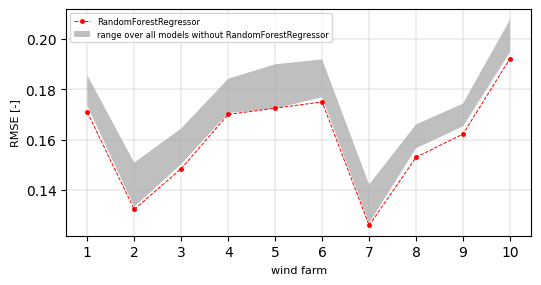

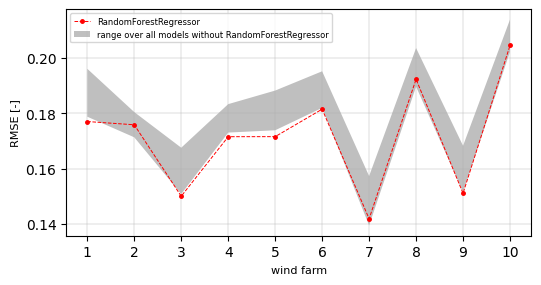

In [4]:
scores = pd.DataFrame(columns = ['ZONE', 'MODEL', 'VALSCORE', 'TESTSCORE'])
scores.set_index('ZONE', inplace=True)

models = ['LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']
fontsize = 8

for model in models:
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    df = df[['CV', 'TESTSCORE', 'MODEL']]
    df.rename(columns={'CV':'VALSCORE'}, inplace=True)
    scores = scores.append(df) 

scores = scores.loc[scores.index != 'TOTAL']
ranges = scores[scores.MODEL != 'RandomForestRegressor']
scores = scores[scores.MODEL == 'RandomForestRegressor'][['VALSCORE', 'TESTSCORE']]

for scoretype in ['VAL', 'TEST']:

    scores['MINVAL'] = [ranges.loc[zone][scoretype + 'SCORE'].min() for zone in ranges.index.unique()]
    scores['MAXVAL'] = [ranges.loc[zone][scoretype + 'SCORE'].max() for zone in ranges.index.unique()]

    ## plot
    fig, ax = plt.subplots(dpi=100, figsize=(6,3))
    ax.plot(scores.index.unique(), scores[scoretype + 'SCORE'], color='r', linestyle='--', marker='.', markersize=5, linewidth=.7)
    ax.fill_between(scores.index.unique(), scores['MINVAL'], scores['MAXVAL'], color = 'gray', alpha=.5, edgecolor=None);
    ax.set_xlabel('wind farm',fontsize=fontsize)
    ax.set_ylabel('RMSE [-]', fontsize=fontsize)
    ax.grid(linewidth=.3)
    ax.legend(['RandomForestRegressor','range over all models without RandomForestRegressor'], fontsize=fontsize - 2, loc = 'upper left')
    ax.set_xticklabels([zone[-1] if len(zone) == 5 else zone[-2:] for zone in scores.index]);
    ax.set_xticklabels(range(1,11));

    fig.savefig('{}{}{}'.format('../images/',scoretype,'_RMSE-By-Windfarms.png'))
